In [83]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV

In [75]:
#df=pd.read_csv('https://raw.githubusercontent.com/reisanar/datasets/master/SleepStudy.csv')
df=pd.read_csv('SleepStudy.csv')
print(df.columns)
#df.to_csv('SleepStudy.csv')
encoder = preprocessing.LabelEncoder()
df['Target']=df['DepressionStatus']
df['LarkOwl_enc']=encoder.fit_transform(df['LarkOwl'])
df['AlcoholUse_enc']=encoder.fit_transform(df['AlcoholUse'])
df['DepressionStatus_enc']=encoder.fit_transform(df['DepressionStatus'])
df['AnxietyStatus_enc']=encoder.fit_transform(df['AnxietyStatus'])
df['Stress_enc']=encoder.fit_transform(df['Stress'])
NUMERIC=['Gender',  
       'DepressionScore',   
         'Stress_enc',
        'DASScore', 'Happiness', 
       'WeekendSleep']


X=df[NUMERIC]
y=df['Target'].apply(lambda x: 1 if ((x=='moderate') | (x=='severe')) else 0)

#y=df['Target'].apply(lambda x:print(x))
#print(y.unique())
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=42)

Index(['Unnamed: 0', 'Gender', 'ClassYear', 'LarkOwl', 'NumEarlyClass',
       'EarlyClass', 'GPA', 'ClassesMissed', 'CognitionZscore',
       'PoorSleepQuality', 'DepressionScore', 'AnxietyScore', 'StressScore',
       'DepressionStatus', 'AnxietyStatus', 'Stress', 'DASScore', 'Happiness',
       'AlcoholUse', 'Drinks', 'WeekdayBed', 'WeekdayRise', 'WeekdaySleep',
       'WeekendBed', 'WeekendRise', 'WeekendSleep', 'AverageSleep',
       'AllNighter'],
      dtype='object')


In [76]:
pipeline= Pipeline([
   ('scaler',StandardScaler()),
    ('pca', PCA()),
   ('clf',LogisticRegression(max_iter=1000,C=5)
   )
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('clf', LogisticRegression(C=5, max_iter=1000))])

In [77]:
log_reg_clf=pipeline['clf']
log_reg_clf.fit(X_train,y_train)
#print(log_reg_clf.coef_)

predictions=log_reg_clf.predict(X_test)
print("Accuracy={}, Precision={}, Recall={}".format(accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions)))

    
original_variables=list(X_train.columns)

zipped_together=list(zip(original_variables,log_reg_clf.coef_[0]))
coefs = [list(x) for x in zipped_together]

coefs=pd.DataFrame(coefs, columns=['Variable','Coefficient'])


coefs.sort_values(by=['Coefficient'], axis=0, inplace=True, ascending=False)

print(coefs)


Accuracy=1.0, Precision=1.0, Recall=1.0
          Variable  Coefficient
1  DepressionScore     3.437236
4        Happiness     0.183269
5     WeekendSleep     0.120139
2       Stress_enc     0.047392
3         DASScore     0.024624
0           Gender    -0.315310


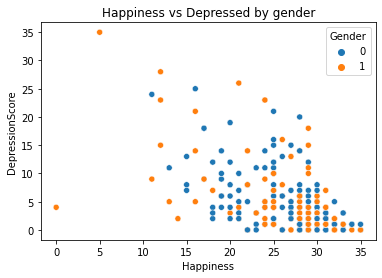

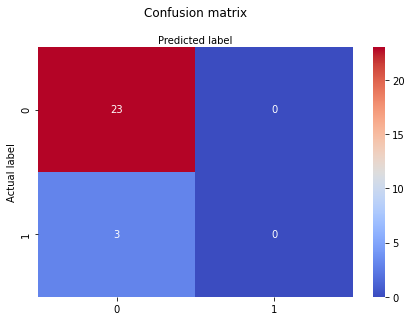

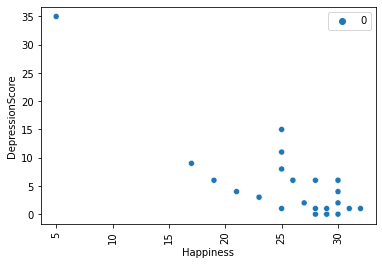

In [78]:
sns.scatterplot(x='Happiness',y='DepressionScore',hue='Gender', data=df)
plt.title("Happiness vs Depressed by gender")
plt.show()

y_pred=pipeline.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

class_names=[1,2]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


pred= y_pred.flatten()
hue=pred
sns.scatterplot(x=X_test['Happiness'],y=X_test['DepressionScore'],hue=hue)
plt.xticks(rotation=90)
plt.show()

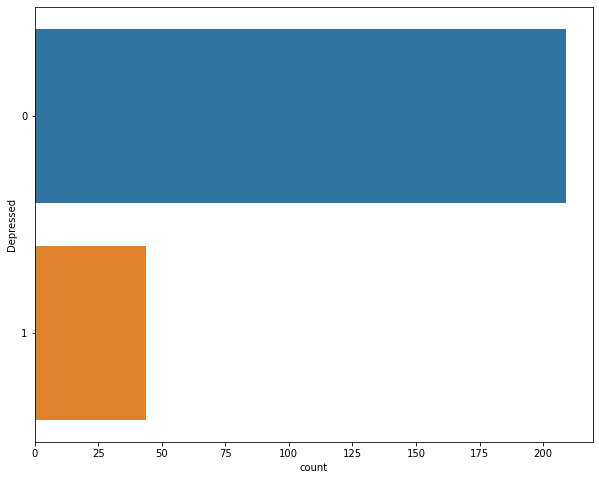

In [79]:
plt.figure(figsize=(10,8))
X2=pd.DataFrame()
X2['Target']=df['Target'].apply(lambda x: 1 if ((x=='moderate') | (x=='severe')) else 0)
sns.countplot(data=X2, y="Target")
plt.ylabel("Depressed")
plt.show()

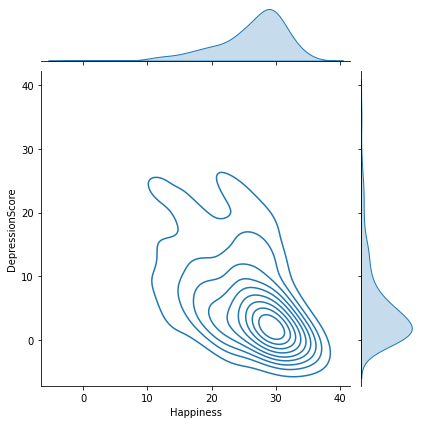

In [80]:
g=sns.JointGrid(data=X, x='Happiness', y='DepressionScore')
g=g.plot_joint(sns.kdeplot)
g=g.plot_marginals(sns.kdeplot, shade=True)
#g=g.annotate(stats.pearson_r)

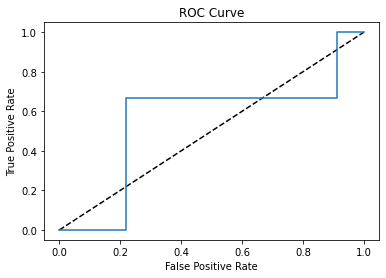

In [82]:
def my_loss(y,w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

#print("Loss:",my_loss(y_test,y_pred))
y_pred_prob=pipeline.predict_proba(X_test)
fpr, tpr, threshholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [88]:
calibrated_clf = CalibratedClassifierCV(base_estimator=pipeline['clf'], method="sigmoid", cv=3)
calibrated_clf.fit(X, y)

print(calibrated_clf.predict_proba(X)[:5, :])


[[0.97151521 0.02848479]
 [0.9953179  0.0046821 ]
 [0.01829911 0.98170089]
 [0.99405208 0.00594792]
 [0.82948843 0.17051157]]
